In [1]:
import xgboost as xgb
#import lightgbm as lbm
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_val_predict


In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline 
pd.set_option('display.max_columns', 500)

X_train = pd.read_csv("data/X_train.csv", index_col=0, error_bad_lines=False)
X_test = pd.read_csv("data/X_test.csv", index_col=0, error_bad_lines=False)
X_train.head(3)

b'Skipping line 2168: expected 31 fields, saw 33\nSkipping line 4822: expected 31 fields, saw 37\nSkipping line 4859: expected 31 fields, saw 37\nSkipping line 7342: expected 31 fields, saw 37\n'


,images_count,image_width,image_height,image_url,product_description,product_size,material,age,warranty,year,color,product_width,wifi,condition,product_length,shoe_size,vintage,brand,author,editor,product_height,weight,price,category,sub_category_1,sub_category_2,sub_category_3,sub_category_4,product_name,store_name
id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
0,3,3458.0,2552.0,https://d1kvfoyrif6wzg.cloudfront.net/assets/i...,Superbe petit top bustier avec explosion de co...,44,100 % polyester,NaN,NaN,NaN,Multicolore,NaN,NaN,bon état,NaN,NaN,False,NaN,NaN,NaN,NaN,200.0,4.5,mode,"tops, t-shirts, débardeurs femme",NaN,NaN,NaN,Top bustier multicolore,Emmaüs 88 Neufchateau
1,2,2486.0,2254.0,https://d1kvfoyrif6wzg.cloudfront.net/assets/i...,"Radio ITT Océnic Flirt, année 70\nPour déco",NaN,Plastique,NaN,NaN,NaN,Jaune,NaN,NaN,en l'état,NaN,NaN,True,ITT Océanic,NaN,NaN,NaN,1000.0,15.0,mobilier - deco,bibelots et objets déco,NaN,NaN,NaN,Radio ITT Océanic,Communauté Emmaüs Thouars (magasin Parthenay)
2,3,1536.0,1536.0,https://d1kvfoyrif6wzg.cloudfront.net/assets/i...,Veste boléro à manches courtes NÛMPH. Gris chi...,40,"Polyester, coton, laine",NaN,NaN,NaN,Gris,NaN,NaN,neuf,NaN,NaN,False,Nûmph,NaN,NaN,NaN,360.0,16.0,label selection,mode,mode femme,NaN,NaN,NaN,Label Emmaüs Chambéry


In [3]:
X_train.shape, X_test.shape

((8880, 30), (2960, 30))

In [4]:
y_train = pd.read_csv("data/y_train.csv", index_col=0)


In [5]:
X_train = X_train.select_dtypes(include=[np.object])


In [6]:
df = pd.concat([X_train,y_train], axis=1)
df.head()

,image_url,product_description,product_size,material,age,warranty,color,wifi,condition,vintage,brand,author,editor,category,sub_category_1,sub_category_2,sub_category_3,sub_category_4,product_name,store_name,duration
id,,,,,,,,,,,,,,,,,,,,,
0,https://d1kvfoyrif6wzg.cloudfront.net/assets/i...,Superbe petit top bustier avec explosion de co...,44,100 % polyester,NaN,NaN,Multicolore,NaN,bon état,False,NaN,NaN,NaN,mode,"tops, t-shirts, débardeurs femme",NaN,NaN,NaN,Top bustier multicolore,Emmaüs 88 Neufchateau,2
1,https://d1kvfoyrif6wzg.cloudfront.net/assets/i...,"Radio ITT Océnic Flirt, année 70\nPour déco",NaN,Plastique,NaN,NaN,Jaune,NaN,en l'état,True,ITT Océanic,NaN,NaN,mobilier - deco,bibelots et objets déco,NaN,NaN,NaN,Radio ITT Océanic,Communauté Emmaüs Thouars (magasin Parthenay),1
2,https://d1kvfoyrif6wzg.cloudfront.net/assets/i...,Veste boléro à manches courtes NÛMPH. Gris chi...,40,"Polyester, coton, laine",NaN,NaN,Gris,NaN,neuf,False,Nûmph,NaN,NaN,label selection,mode,mode femme,NaN,NaN,NaN,Label Emmaüs Chambéry,1
3,https://d1kvfoyrif6wzg.cloudfront.net/assets/i...,Encrier plumier en verre. De forme carrée le ...,NaN,NaN,NaN,NaN,NaN,NaN,bon état,NaN,NaN,NaN,NaN,mobilier - deco,autres objets,NaN,NaN,NaN,Encrier Plumier en verre,Emmaüs Lyon,1
4,https://d1kvfoyrif6wzg.cloudfront.net/assets/i...,Si vous souhaitez acquérir un appareil puissan...,NaN,NaN,NaN,6 mois,Blanc,True,reconditionné,NaN,NaN,NaN,NaN,multimédia,smartphones,NaN,NaN,NaN,HUAWEI Honor 5X Blanc - Débloqué - Très bon état.,La Bootique des Ateliers du Bocage,0


In [7]:
#list(df.select_dtypes(include=[np.number]).columns.values)

### Feature Engineering

In [8]:
from sklearn import preprocessing
conditions = ['vide','autre','reconditionné','comme neuf','neuf','en l\'état','bon état']
le = preprocessing.LabelEncoder()
le.fit(conditions)

def fix_condition(df):
    df['condition'].fillna('vide',inplace=True)    
    df['condition'].apply(lambda x : x if x in conditions else 'autre')
    df['condition'] = le.transform(df['condition'])
    
fix_condition(df)

In [9]:
categories = ['category','sub_category_1','sub_category_2','sub_category_3','sub_category_4']
df['categories'] = df[categories].fillna('').apply(lambda x: ' '.join(x), axis=1)
df['categories'][:5]

id
0      mode tops, t-shirts, débardeurs femme   
1    mobilier - deco bibelots et objets déco   
2             label selection mode mode femme  
3              mobilier - deco autres objets   
4                     multimédia smartphones   
Name: categories, dtype: object

### text vectorisation

In [10]:
import string
import re 
import itertools
import nltk
import operator
from bs4 import BeautifulSoup             
from nltk.corpus import stopwords
from nltk import pos_tag
from nltk.stem.snowball import FrenchStemmer 


def tokenizer(text, remove_stopwords=True, stemming=True, pos_tagging=False):
        
    # convert to lower case
    #text = BeautifulSoup(text, "lxml").get_text()
    text = text.lower()
    
    # remove punctuation (preserving intra-word dashes)
    punct = string.punctuation.replace('-', '')
    text = ''.join(l for l in text if l not in punct)
    
    # strip extra white space
    text = re.sub(' +|\n+|\r+',' ',text)
    # strip leading and trailing white space
    text = text.strip()
    # tokenize (split based on whitespace)
    ### fill the gap ###
    tokens = text.split()
    
    if remove_stopwords:
        stpwds = stopwords.words('french')
        # remove stopwords
        tokens = [t for t in tokens if t not in stpwds]
        
    if stemming:
        #stemming words
        stemmed_tokens = [] #declare an empty list to hold our stemmed words
        stemmer = FrenchStemmer() #create a stemmer object in the FrenchStemmer class
        for token in tokens:
            stemmed_token=stemmer.stem(token) #stem the word
            stemmed_tokens.append(stemmed_token) #add it to our stemmed word list
        #stemmed_tokens.sort() #sort the stemmed_words
        tokens = stemmed_tokens
        
    if pos_tagging == True:
        # apply POS-tagging
        tagged_tokens = pos_tag(tokens)
        # retain only nouns and adjectives
        tokens_keep = []
        for i in range(len(tagged_tokens)):
            item = tagged_tokens[i]
            if (
            item[1] == 'NN' or
            item[1] == 'NNS' or
            item[1] == 'NNP' or
            item[1] == 'NNPS' or
            item[1] == 'JJ' or
            item[1] == 'JJS' or
            item[1] == 'JJR' or
            item[1] == 'CD'
            ):
                tokens_keep.append(item[0])
        tokens = tokens_keep
    
    return(tokens)

In [11]:
#df['prod_desc_tokens'] = df['product_description'].apply(lambda text: tokenizer(text))

In [28]:
from sklearn.feature_extraction.text import TfidfVectorizer

# min_df is minimum number of documents that contain a term t
# max_features is maximum number of unique tokens (across documents) that we'd consider
# TfidfVectorizer preprocesses the descriptions using the tokenizer we defined above

vectorizer = TfidfVectorizer(min_df=10, 
                             max_features=200, 
                             tokenizer=tokenizer, 
                             ngram_range=(1, 2))


vectorizer2 = TfidfVectorizer(min_df=10, 
                             max_features=200, 
                             tokenizer=tokenizer, 
                             ngram_range=(1, 2))

In [29]:
def vectorize_tfidf(df,col,prefix,vectorizer,train_or_test):
    if train_or_test == 'train':
        vect = vectorizer.fit_transform(list(df[col]))
    else:
        vect = vectorizer.transform(list(df[col]))
        
    tfidf_cols= list(map(lambda x: prefix+'_'+x, vectorizer.get_feature_names()))
    tfidf = pd.DataFrame(vect.toarray(), columns=tfidf_cols)
    df_tfidf = pd.concat([df, tfidf], axis=1)
    return df_tfidf

In [31]:
df_tfidf_prod_desc = vectorize_tfidf(df,'product_description','prod_desc',vectorizer,"train")
df_tfidf_prod_desc.sample(4)

,image_url,product_description,product_size,material,age,warranty,color,wifi,condition,vintage,brand,author,editor,category,sub_category_1,sub_category_2,sub_category_3,sub_category_4,product_name,store_name,duration,categories,prod_desc_-,prod_desc_- roman,prod_desc_1,prod_desc_100,prod_desc_2,prod_desc_2 poch,prod_desc_3,prod_desc_4,prod_desc_40,prod_desc_5,prod_desc_5 8,prod_desc_6,prod_desc_8,prod_desc_8 jour,prod_desc_a,prod_desc_achet,prod_desc_achet livr,prod_desc_actuel,prod_desc_actuel boutiqu,prod_desc_ains,prod_desc_ains réemploi,prod_desc_ancien,prod_desc_anné,prod_desc_band,prod_desc_bas,prod_desc_bel,prod_desc_blanc,prod_desc_bleu,prod_desc_bois,prod_desc_bon,prod_desc_bon état,prod_desc_bon étatbr,prod_desc_boutiqu,prod_desc_boutiqu del,prod_desc_bouton,prod_desc_carton,prod_desc_cet,prod_desc_cet exemplair,prod_desc_cm,prod_desc_cod,prod_desc_cod isbn,prod_desc_col,prod_desc_collect,prod_desc_color,prod_desc_composit,prod_desc_contractuel,prod_desc_contractuel recevr,prod_desc_coton,prod_desc_couleur,prod_desc_coup,prod_desc_court,prod_desc_couvertur,prod_desc_couvertur présent,prod_desc_couvertur soupl,prod_desc_cuir,prod_desc_côt,prod_desc_del,prod_desc_del 5,prod_desc_dessin,prod_desc_deux,prod_desc_dev,prod_desc_dimens,prod_desc_disponibl,prod_desc_disponibl actuel,prod_desc_doccas,prod_desc_doccas label,prod_desc_doccas lign,prod_desc_doccas écrit,prod_desc_dor,prod_desc_dos,prod_desc_doubl,prod_desc_doublur,prod_desc_dun,prod_desc_dun librair,prod_desc_décor,prod_desc_emmaü,prod_desc_emmaü ains,prod_desc_emmaü strong,prod_desc_exemplair,prod_desc_femm,prod_desc_fermetur,prod_desc_format,prod_desc_format moyen,prod_desc_format poch,prod_desc_franc,prod_desc_grand,prod_desc_gris,prod_desc_général,prod_desc_général -,prod_desc_hauteur,prod_desc_imprim,prod_desc_intérieur,prod_desc_isbn,prod_desc_isbn référent,prod_desc_jour,prod_desc_jour ppen,prod_desc_label,prod_desc_label emmaü,prod_desc_largeur,prod_desc_le,prod_desc_lemploi,prod_desc_lemploi sein,prod_desc_lenvironnementp,prod_desc_lexemplair,prod_desc_lexemplair disponibl,prod_desc_librair,prod_desc_librair solidair,prod_desc_lign,prod_desc_lign souten,prod_desc_linsert,prod_desc_linsert professionnel,prod_desc_littératur,prod_desc_littératur général,prod_desc_livr,prod_desc_livr doccas,prod_desc_livr préserv,prod_desc_longu,prod_desc_longueur,prod_desc_lot,prod_desc_légal,prod_desc_légal vent,prod_desc_léger,prod_desc_main,prod_desc_manch,prod_desc_manch longu,prod_desc_marqu,prod_desc_marron,prod_desc_mati,prod_desc_motif,prod_desc_moyen,prod_desc_métal,prod_desc_nest,prod_desc_nest contractuel,prod_desc_noir,prod_desc_non,prod_desc_pag,prod_desc_paru,prod_desc_pcouleur,prod_desc_pet,prod_desc_petit,prod_desc_photo,prod_desc_photo couvertur,prod_desc_plus,prod_desc_poch,prod_desc_polyest,prod_desc_port,prod_desc_ppen,prod_desc_ppen achet,prod_desc_ppstronginform,prod_desc_ppstronginform légal,prod_desc_professionnel,prod_desc_professionnel lemploi,prod_desc_propos,prod_desc_propos cet,prod_desc_présent,prod_desc_présent nest,prod_desc_préserv,prod_desc_préserv lenvironnementp,prod_desc_pstronglivr,prod_desc_pstronglivr doccas,prod_desc_ptaill,prod_desc_quelqu,prod_desc_recevr,prod_desc_recevr lexemplair,prod_desc_rob,prod_desc_roman,prod_desc_roug,prod_desc_réemploi,prod_desc_réemploi livr,prod_desc_référent,prod_desc_référent livr,prod_desc_sac,prod_desc_san,prod_desc_sein,prod_desc_sein dun,prod_desc_solidair,prod_desc_solidair emmaü,prod_desc_soupl,prod_desc_soupl format,prod_desc_souten,prod_desc_souten linsert,prod_desc_strong,prod_desc_strong photo,prod_desc_surpiqûr,prod_desc_taill,prod_desc_tissu,prod_desc_tout,prod_desc_tres,prod_desc_tres bon,prod_desc_vent,prod_desc_vent livr,prod_desc_vest,prod_desc_vintag,prod_desc_x,prod_desc_zipp,prod_desc_écrit,prod_desc_édit,prod_desc_état,prod_desc_étatbr,prod_desc_étatbr cod
id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,

tfidf_info = dict(zip(vectorizer.get_feature_names(), vectorizer.idf_))
tfidf_info = pd.DataFrame(columns=['tfidf']).from_dict(dict(tfidf_info), orient='index')
tfidf_info.columns = ['tfidf']
tfidf_info.sort_values(by='tfidf', ascending=False)[:20]

In [30]:
df_tfidf_categories = vectorize_tfidf(df_tfidf_prod_desc,'categories','cat',vectorizer2,"train")
df_tfidf_categories.sample(4)

,image_url,product_description,product_size,material,age,warranty,color,wifi,condition,vintage,brand,author,editor,category,sub_category_1,sub_category_2,sub_category_3,sub_category_4,product_name,store_name,duration,categories,prod_desc_-,prod_desc_- roman,prod_desc_1,prod_desc_100,prod_desc_2,prod_desc_2 poch,prod_desc_3,prod_desc_4,prod_desc_40,prod_desc_5,prod_desc_5 8,prod_desc_6,prod_desc_8,prod_desc_8 jour,prod_desc_a,prod_desc_achet,prod_desc_achet livr,prod_desc_actuel,prod_desc_actuel boutiqu,prod_desc_ains,prod_desc_ains réemploi,prod_desc_ancien,prod_desc_anné,prod_desc_band,prod_desc_bas,prod_desc_bel,prod_desc_blanc,prod_desc_bleu,prod_desc_bois,prod_desc_bon,prod_desc_bon état,prod_desc_bon étatbr,prod_desc_boutiqu,prod_desc_boutiqu del,prod_desc_bouton,prod_desc_carton,prod_desc_cet,prod_desc_cet exemplair,prod_desc_cm,prod_desc_cod,prod_desc_cod isbn,prod_desc_col,prod_desc_collect,prod_desc_color,prod_desc_composit,prod_desc_contractuel,prod_desc_contractuel recevr,prod_desc_coton,prod_desc_couleur,prod_desc_coup,prod_desc_court,prod_desc_couvertur,prod_desc_couvertur présent,prod_desc_couvertur soupl,prod_desc_cuir,prod_desc_côt,prod_desc_del,prod_desc_del 5,prod_desc_dessin,prod_desc_deux,prod_desc_dev,prod_desc_dimens,prod_desc_disponibl,prod_desc_disponibl actuel,prod_desc_doccas,prod_desc_doccas label,prod_desc_doccas lign,prod_desc_doccas écrit,prod_desc_dor,prod_desc_dos,prod_desc_doubl,prod_desc_doublur,prod_desc_dun,prod_desc_dun librair,prod_desc_décor,prod_desc_emmaü,prod_desc_emmaü ains,prod_desc_emmaü strong,prod_desc_exemplair,prod_desc_femm,prod_desc_fermetur,prod_desc_format,prod_desc_format moyen,prod_desc_format poch,prod_desc_franc,prod_desc_grand,prod_desc_gris,prod_desc_général,prod_desc_général -,prod_desc_hauteur,prod_desc_imprim,prod_desc_intérieur,prod_desc_isbn,prod_desc_isbn référent,prod_desc_jour,prod_desc_jour ppen,prod_desc_label,prod_desc_label emmaü,prod_desc_largeur,prod_desc_le,prod_desc_lemploi,prod_desc_lemploi sein,prod_desc_lenvironnementp,prod_desc_lexemplair,prod_desc_lexemplair disponibl,prod_desc_librair,prod_desc_librair solidair,prod_desc_lign,prod_desc_lign souten,prod_desc_linsert,prod_desc_linsert professionnel,prod_desc_littératur,prod_desc_littératur général,prod_desc_livr,prod_desc_livr doccas,prod_desc_livr préserv,prod_desc_longu,prod_desc_longueur,prod_desc_lot,prod_desc_légal,prod_desc_légal vent,prod_desc_léger,prod_desc_main,prod_desc_manch,prod_desc_manch longu,prod_desc_marqu,prod_desc_marron,prod_desc_mati,prod_desc_motif,prod_desc_moyen,prod_desc_métal,prod_desc_nest,prod_desc_nest contractuel,prod_desc_noir,prod_desc_non,prod_desc_pag,prod_desc_paru,prod_desc_pcouleur,prod_desc_pet,prod_desc_petit,prod_desc_photo,prod_desc_photo couvertur,prod_desc_plus,prod_desc_poch,prod_desc_polyest,prod_desc_port,prod_desc_ppen,prod_desc_ppen achet,prod_desc_ppstronginform,prod_desc_ppstronginform légal,prod_desc_professionnel,prod_desc_professionnel lemploi,prod_desc_propos,prod_desc_propos cet,prod_desc_présent,prod_desc_présent nest,prod_desc_préserv,prod_desc_préserv lenvironnementp,prod_desc_pstronglivr,prod_desc_pstronglivr doccas,prod_desc_ptaill,prod_desc_quelqu,prod_desc_recevr,prod_desc_recevr lexemplair,prod_desc_rob,prod_desc_roman,prod_desc_roug,prod_desc_réemploi,prod_desc_réemploi livr,prod_desc_référent,prod_desc_référent livr,prod_desc_sac,prod_desc_san,prod_desc_sein,prod_desc_sein dun,prod_desc_solidair,prod_desc_solidair emmaü,prod_desc_soupl,prod_desc_soupl format,prod_desc_souten,prod_desc_souten linsert,prod_desc_strong,prod_desc_strong photo,prod_desc_surpiqûr,prod_desc_taill,prod_desc_tissu,prod_desc_tout,prod_desc_tres,prod_desc_tres bon,prod_desc_vent,prod_desc_vent livr,prod_desc_vest,prod_desc_vintag,prod_desc_x,prod_desc_zipp,prod_desc_écrit,prod_desc_édit,prod_desc_état,prod_desc_étatbr,prod_desc_étatbr cod,cat_-,cat_- deco,cat_6,cat_accessoir,cat_accessoir femm,cat_accessoir homm,cat_accessoir maroquiner,cat_accessoir photo,cat_a

### Modelisation

In [16]:
df_vectoried = df_tfidf_prod_desc
df_num = df_vectoried.select_dtypes(include=[np.number])
print(df_num.shape)
df_num.head()

(8880, 202)


,condition,duration,prod_desc_-,prod_desc_- roman,prod_desc_1,prod_desc_100,prod_desc_2,prod_desc_2 poch,prod_desc_3,prod_desc_4,prod_desc_40,prod_desc_5,prod_desc_5 8,prod_desc_6,prod_desc_8,prod_desc_8 jour,prod_desc_a,prod_desc_achet,prod_desc_achet livr,prod_desc_actuel,prod_desc_actuel boutiqu,prod_desc_ains,prod_desc_ains réemploi,prod_desc_ancien,prod_desc_anné,prod_desc_band,prod_desc_bas,prod_desc_bel,prod_desc_blanc,prod_desc_bleu,prod_desc_bois,prod_desc_bon,prod_desc_bon état,prod_desc_bon étatbr,prod_desc_boutiqu,prod_desc_boutiqu del,prod_desc_bouton,prod_desc_carton,prod_desc_cet,prod_desc_cet exemplair,prod_desc_cm,prod_desc_cod,prod_desc_cod isbn,prod_desc_col,prod_desc_collect,prod_desc_color,prod_desc_composit,prod_desc_contractuel,prod_desc_contractuel recevr,prod_desc_coton,prod_desc_couleur,prod_desc_coup,prod_desc_court,prod_desc_couvertur,prod_desc_couvertur présent,prod_desc_couvertur soupl,prod_desc_cuir,prod_desc_côt,prod_desc_del,prod_desc_del 5,prod_desc_dessin,prod_desc_deux,prod_desc_dev,prod_desc_dimens,prod_desc_disponibl,prod_desc_disponibl actuel,prod_desc_doccas,prod_desc_doccas label,prod_desc_doccas lign,prod_desc_doccas écrit,prod_desc_dor,prod_desc_dos,prod_desc_doubl,prod_desc_doublur,prod_desc_dun,prod_desc_dun librair,prod_desc_décor,prod_desc_emmaü,prod_desc_emmaü ains,prod_desc_emmaü strong,prod_desc_exemplair,prod_desc_femm,prod_desc_fermetur,prod_desc_format,prod_desc_format moyen,prod_desc_format poch,prod_desc_franc,prod_desc_grand,prod_desc_gris,prod_desc_général,prod_desc_général -,prod_desc_hauteur,prod_desc_imprim,prod_desc_intérieur,prod_desc_isbn,prod_desc_isbn référent,prod_desc_jour,prod_desc_jour ppen,prod_desc_label,prod_desc_label emmaü,prod_desc_largeur,prod_desc_le,prod_desc_lemploi,prod_desc_lemploi sein,prod_desc_lenvironnementp,prod_desc_lexemplair,prod_desc_lexemplair disponibl,prod_desc_librair,prod_desc_librair solidair,prod_desc_lign,prod_desc_lign souten,prod_desc_linsert,prod_desc_linsert professionnel,prod_desc_littératur,prod_desc_littératur général,prod_desc_livr,prod_desc_livr doccas,prod_desc_livr préserv,prod_desc_longu,prod_desc_longueur,prod_desc_lot,prod_desc_légal,prod_desc_légal vent,prod_desc_léger,prod_desc_main,prod_desc_manch,prod_desc_manch longu,prod_desc_marqu,prod_desc_marron,prod_desc_mati,prod_desc_motif,prod_desc_moyen,prod_desc_métal,prod_desc_nest,prod_desc_nest contractuel,prod_desc_noir,prod_desc_non,prod_desc_pag,prod_desc_paru,prod_desc_pcouleur,prod_desc_pet,prod_desc_petit,prod_desc_photo,prod_desc_photo couvertur,prod_desc_plus,prod_desc_poch,prod_desc_polyest,prod_desc_port,prod_desc_ppen,prod_desc_ppen achet,prod_desc_ppstronginform,prod_desc_ppstronginform légal,prod_desc_professionnel,prod_desc_professionnel lemploi,prod_desc_propos,prod_desc_propos cet,prod_desc_présent,prod_desc_présent nest,prod_desc_préserv,prod_desc_préserv lenvironnementp,prod_desc_pstronglivr,prod_desc_pstronglivr doccas,prod_desc_ptaill,prod_desc_quelqu,prod_desc_recevr,prod_desc_recevr lexemplair,prod_desc_rob,prod_desc_roman,prod_desc_roug,prod_desc_réemploi,prod_desc_réemploi livr,prod_desc_référent,prod_desc_référent livr,prod_desc_sac,prod_desc_san,prod_desc_sein,prod_desc_sein dun,prod_desc_solidair,prod_desc_solidair emmaü,prod_desc_soupl,prod_desc_soupl format,prod_desc_souten,prod_desc_souten linsert,prod_desc_strong,prod_desc_strong photo,prod_desc_surpiqûr,prod_desc_taill,prod_desc_tissu,prod_desc_tout,prod_desc_tres,prod_desc_tres bon,prod_desc_vent,prod_desc_vent livr,prod_desc_vest,prod_desc_vintag,prod_desc_x,prod_desc_zipp,prod_desc_écrit,prod_desc_édit,prod_desc_état,prod_desc_étatbr,prod_desc_étatbr cod
id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
0,1,2,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.00000,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.

In [17]:
y_train_num = df_num['duration']
feats_to_drop = ['duration']#+feats_to_remove

In [18]:
X_train_num = df_num.drop(feats_to_drop, axis=1)
X_train_num.shape, y_train_num.shape

((8880, 201), (8880,))

In [19]:
X_train_num.head()

,condition,prod_desc_-,prod_desc_- roman,prod_desc_1,prod_desc_100,prod_desc_2,prod_desc_2 poch,prod_desc_3,prod_desc_4,prod_desc_40,prod_desc_5,prod_desc_5 8,prod_desc_6,prod_desc_8,prod_desc_8 jour,prod_desc_a,prod_desc_achet,prod_desc_achet livr,prod_desc_actuel,prod_desc_actuel boutiqu,prod_desc_ains,prod_desc_ains réemploi,prod_desc_ancien,prod_desc_anné,prod_desc_band,prod_desc_bas,prod_desc_bel,prod_desc_blanc,prod_desc_bleu,prod_desc_bois,prod_desc_bon,prod_desc_bon état,prod_desc_bon étatbr,prod_desc_boutiqu,prod_desc_boutiqu del,prod_desc_bouton,prod_desc_carton,prod_desc_cet,prod_desc_cet exemplair,prod_desc_cm,prod_desc_cod,prod_desc_cod isbn,prod_desc_col,prod_desc_collect,prod_desc_color,prod_desc_composit,prod_desc_contractuel,prod_desc_contractuel recevr,prod_desc_coton,prod_desc_couleur,prod_desc_coup,prod_desc_court,prod_desc_couvertur,prod_desc_couvertur présent,prod_desc_couvertur soupl,prod_desc_cuir,prod_desc_côt,prod_desc_del,prod_desc_del 5,prod_desc_dessin,prod_desc_deux,prod_desc_dev,prod_desc_dimens,prod_desc_disponibl,prod_desc_disponibl actuel,prod_desc_doccas,prod_desc_doccas label,prod_desc_doccas lign,prod_desc_doccas écrit,prod_desc_dor,prod_desc_dos,prod_desc_doubl,prod_desc_doublur,prod_desc_dun,prod_desc_dun librair,prod_desc_décor,prod_desc_emmaü,prod_desc_emmaü ains,prod_desc_emmaü strong,prod_desc_exemplair,prod_desc_femm,prod_desc_fermetur,prod_desc_format,prod_desc_format moyen,prod_desc_format poch,prod_desc_franc,prod_desc_grand,prod_desc_gris,prod_desc_général,prod_desc_général -,prod_desc_hauteur,prod_desc_imprim,prod_desc_intérieur,prod_desc_isbn,prod_desc_isbn référent,prod_desc_jour,prod_desc_jour ppen,prod_desc_label,prod_desc_label emmaü,prod_desc_largeur,prod_desc_le,prod_desc_lemploi,prod_desc_lemploi sein,prod_desc_lenvironnementp,prod_desc_lexemplair,prod_desc_lexemplair disponibl,prod_desc_librair,prod_desc_librair solidair,prod_desc_lign,prod_desc_lign souten,prod_desc_linsert,prod_desc_linsert professionnel,prod_desc_littératur,prod_desc_littératur général,prod_desc_livr,prod_desc_livr doccas,prod_desc_livr préserv,prod_desc_longu,prod_desc_longueur,prod_desc_lot,prod_desc_légal,prod_desc_légal vent,prod_desc_léger,prod_desc_main,prod_desc_manch,prod_desc_manch longu,prod_desc_marqu,prod_desc_marron,prod_desc_mati,prod_desc_motif,prod_desc_moyen,prod_desc_métal,prod_desc_nest,prod_desc_nest contractuel,prod_desc_noir,prod_desc_non,prod_desc_pag,prod_desc_paru,prod_desc_pcouleur,prod_desc_pet,prod_desc_petit,prod_desc_photo,prod_desc_photo couvertur,prod_desc_plus,prod_desc_poch,prod_desc_polyest,prod_desc_port,prod_desc_ppen,prod_desc_ppen achet,prod_desc_ppstronginform,prod_desc_ppstronginform légal,prod_desc_professionnel,prod_desc_professionnel lemploi,prod_desc_propos,prod_desc_propos cet,prod_desc_présent,prod_desc_présent nest,prod_desc_préserv,prod_desc_préserv lenvironnementp,prod_desc_pstronglivr,prod_desc_pstronglivr doccas,prod_desc_ptaill,prod_desc_quelqu,prod_desc_recevr,prod_desc_recevr lexemplair,prod_desc_rob,prod_desc_roman,prod_desc_roug,prod_desc_réemploi,prod_desc_réemploi livr,prod_desc_référent,prod_desc_référent livr,prod_desc_sac,prod_desc_san,prod_desc_sein,prod_desc_sein dun,prod_desc_solidair,prod_desc_solidair emmaü,prod_desc_soupl,prod_desc_soupl format,prod_desc_souten,prod_desc_souten linsert,prod_desc_strong,prod_desc_strong photo,prod_desc_surpiqûr,prod_desc_taill,prod_desc_tissu,prod_desc_tout,prod_desc_tres,prod_desc_tres bon,prod_desc_vent,prod_desc_vent livr,prod_desc_vest,prod_desc_vintag,prod_desc_x,prod_desc_zipp,prod_desc_écrit,prod_desc_édit,prod_desc_état,prod_desc_étatbr,prod_desc_étatbr cod
id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
0,1,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.00000,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.

In [20]:
from xgboost import XGBClassifier
clf = XGBClassifier(n_estimators = 150, 
                       learning_rate = 0.05,
                       max_depth=6,
                       n_jobs=1,
                       alpha = 0.1)

clf.fit(X_train_num, y_train_num, 
        verbose=False,
        early_stopping_rounds=10, 
        eval_metric="mlogloss",
        eval_set=[(X_train_num, y_train_num)]
        )

XGBClassifier(alpha=0.1, base_score=0.5, booster='gbtree',
       colsample_bylevel=1, colsample_bytree=1, gamma=0,
       learning_rate=0.05, max_delta_step=0, max_depth=6,
       min_child_weight=1, missing=None, n_estimators=150, n_jobs=1,
       nthread=None, objective='multi:softprob', random_state=0,
       reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
       silent=True, subsample=1)

### Evaluation

In [21]:
print(clf.best_score)
#clf.evals_result_


0.896901


|eval|local|submission|
|---|---|---|
|xgb + tfidf200|1.053205|1.06754|
|xgb(es = 20) + tfidf200 (prod desc)|1.024326|1.05221|
|xgb(es = 100) + tfidf200 (prod desc)|0.927637|1.02822|
|xgb(es = 300) + tfidf200 (prod desc)|0.833815|1.02947|
|xgb(es = 150) + tfidf200 (prod desc/categories)|0.896901|1.02672|


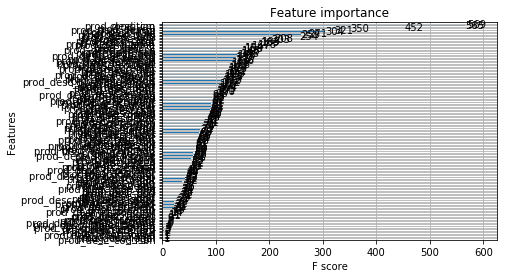

In [22]:
xgb.plot_importance(clf)
# xgb.plot_tree(bst, num_trees=2)
# xgb.to_graphviz(bst, num_trees=2)

In [23]:
fit = clf.fit(X_train_num, y_train_num)
ft_weights = pd.DataFrame(fit.feature_importances_, columns=['weights'], index=X_train_num.columns)

In [24]:
ft_weights.sort_values(by='weights', ascending=False)[:30]


,weights
prod_desc_cm,0.044436
condition,0.044123
prod_desc_-,0.035299
prod_desc_femm,0.027333
prod_desc_taill,0.025068
prod_desc_le,0.023741
prod_desc_mati,0.021164
prod_desc_bon,0.020226
prod_desc_noir,0.019836
prod_desc_x,0.016244


### submission 

In [32]:
X_test_ready = X_test.select_dtypes(include=[np.object])
fix_condition(X_test_ready)
X_test_ready = vectorize_tfidf(X_test_ready,'product_description','prod_desc',vectorizer,"test")
X_test_ready['categories'] = X_test_ready[categories].fillna('').apply(lambda x: ' '.join(x), axis=1)
X_test_ready = vectorize_tfidf(X_test_ready,'categories','cat',vectorizer2,"test")
X_test_ready = X_test_ready[X_train_num.columns] # no shoes column


C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if __name__ == '__main__':


In [33]:
df_test_num = X_test_ready.select_dtypes(include=[np.number])

predicted_test_tr = clf.predict_proba(df_test_num)
predicted_test_tr

array([[0.2633657 , 0.36505514, 0.3715792 ],
       [0.3513467 , 0.5449308 , 0.10372249],
       [0.1705587 , 0.81297   , 0.01647131],
       ...,
       [0.37844783, 0.31418484, 0.30736735],
       [0.3013719 , 0.35314548, 0.3454826 ],
       [0.25839403, 0.31054384, 0.4310622 ]], dtype=float32)

In [34]:
pred_test = predicted_test_tr
df_submission = pd.DataFrame(pred_test, index=X_test.index)

df_submission.head()

,0,1,2
id,,,
0,0.263366,0.365055,0.371579
1,0.351347,0.544931,0.103722
2,0.170559,0.812970,0.016471
3,0.399130,0.195858,0.405012
4,0.370953,0.280720,0.348327


In [35]:
import io, math, requests

# Only works in Python3, see comment below for Python2
def submit_prediction(df, sep=',', **kwargs):
    # TOKEN to recover on the platform: "Submissions"> "Submit from your Python Notebook"
    TOKEN=''  
    URL='https://qscore.datascience-olympics.com/api/submissions'
    #buffer = io.BytesIO() # Python 2
    buffer = io.StringIO() # Python 3
    df.to_csv(buffer, sep=sep, **kwargs)
    buffer.seek(0)
    r = requests.post(URL, headers={'Authorization': 'Bearer {}'.format(TOKEN)},files={'datafile': buffer})
    if r.status_code == 429:
        raise Exception('Submissions are too close. Next submission is only allowed in {} seconds.'.format(int(math.ceil(int(r.headers['x-rate-limit-remaining']) / 1000.0))))
    if r.status_code != 200:
        raise Exception(r.text)



In [36]:
submit_prediction(df_submission, sep=',', index=True)